In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

afreq = pd.read_csv('/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/array/08.check_maf_hwe/cteph_agp3k.ajsa.qc.norm.auto_chr.afreq', 
                    sep='\s+', header=0)
hardy = pd.read_csv('/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/array/08.check_maf_hwe/cteph_agp3k.ajsa.qc.norm.auto_chr.hardy',
                    sep='\s+', header=0)

afreq_agp3k = pd.read_csv('/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/array/08.check_maf_hwe/agp3k.ajsa.qc.norm.auto_chr.afreq', 
                    sep='\s+', header=0)
hardy_agp3k = pd.read_csv('/LARGE0/gr10478/b37974/Pulmonary_Hypertension/cteph_agp3k/array/08.check_maf_hwe/agp3k.ajsa.qc.norm.auto_chr.hardy',
                    sep='\s+', header=0)


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3734229/234122869.py:6: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+', header=0)
/tmp/ipykernel_3734229/234122869.py:8: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+', header=0)
/tmp/ipykernel_3734229/234122869.py:11: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+', header=0)
/tmp/ipykernel_3734229/234122869.py:13: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+', header=0)


In [11]:
# import pandas as pd
# import subprocess

# input_ids = afreq['ID']

# with open('targets.txt', 'w') as f:
#     for id_ in input_ids:
#         chrom, pos, ref, alt = id_.split(':')
#         f.write(f"{chrom}\t{pos}\t{ref},{alt}\n")
        
# subprocess.run("bgzip -c targets.txt > als.tsv.gz", shell=True, check=True)
# subprocess.run("tabix -s1 -b2 -e2 als.tsv.gz", shell=True, check=True)

# tommo_vcf = '/LARGE0/gr10478/b37974/Pulmonary_Hypertension/ToMMo_60KJPN/tommo-60kjpn-20240904-GRCh38-snvindel-af-autosome.norm.vcf.gz'

# cmd = [
#     "bcftools", "query",
#     "--targets-file", "als.tsv.gz",
#     "-f", "%CHROM:%POS:%REF:%ALT\\t%FILTER\\t%AF\\n",
#     "-o", "af_output.tsv",
#     tommo_vcf
# ]

# subprocess.run(cmd, check=True)


CompletedProcess(args=['bcftools', 'query', '--targets-file', 'als.tsv.gz', '-f', '%CHROM:%POS:%REF:%ALT\\t%FILTER\\t%AF\\n', '-o', 'af_output.tsv', '/LARGE0/gr10478/b37974/Pulmonary_Hypertension/ToMMo_60KJPN/tommo-60kjpn-20240904-GRCh38-snvindel-af-autosome.norm.vcf.gz'], returncode=0)

In [2]:
tommo_af = pd.read_csv('af_output.tsv', sep='\t', header=None)
tommo_af.columns = ['ID', 'TOMMO_FILTER', 'TOMMO_AF']
tommo_af[['CHROM', 'POS', 'REF', 'ALT']] = tommo_af['ID'].str.split(':', expand=True)
tommo_af['CHROM'] = tommo_af['CHROM'].str.replace('chr', '', regex=False)

In [3]:
def process_data(tommo_af, afreq, hardy):
    
    afreq = afreq.merge(tommo_af[['ID', 'TOMMO_FILTER', 'TOMMO_AF']], on='ID', how='left')

    afreq['ID_REF_ALT_REV_FLAG'] = afreq.apply(
        lambda row: 'YES' if row['REF'] == row['ID'].split(':')[3] and row['ALT'] == row['ID'].split(':')[2] else 'NO',
        axis=1
    )
    
    afreq = afreq.merge(hardy[['ID', 'P']], on='ID', how='left')
    
    afreq['MAF'] = afreq['ALT_FREQS'].apply(lambda x: min(x, 1 - x))
    
    summary_df = afreq[['#CHROM', 'ID', 'REF', 'ALT', 'MAF', 'ALT_FREQS', 'TOMMO_AF', 'TOMMO_FILTER', 'P', 'ID_REF_ALT_REV_FLAG']]
    
    return summary_df

summary_df = process_data(tommo_af, afreq, hardy)


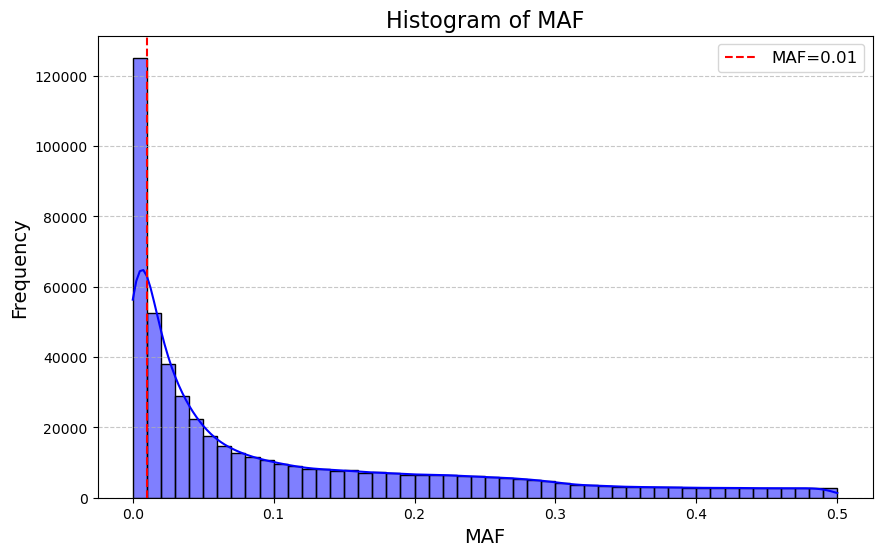

In [13]:
import seaborn as sns

plt.style.use('default')  # 使用默认样式

plt.figure(figsize=(10, 6))
sns.histplot(summary_df['MAF'], bins=50, kde=True, color='blue') 

plt.axvline(x=0.01, color='red', linestyle='--', label='MAF=0.01')
plt.title('Histogram of MAF', fontsize=16)
plt.xlabel('MAF', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

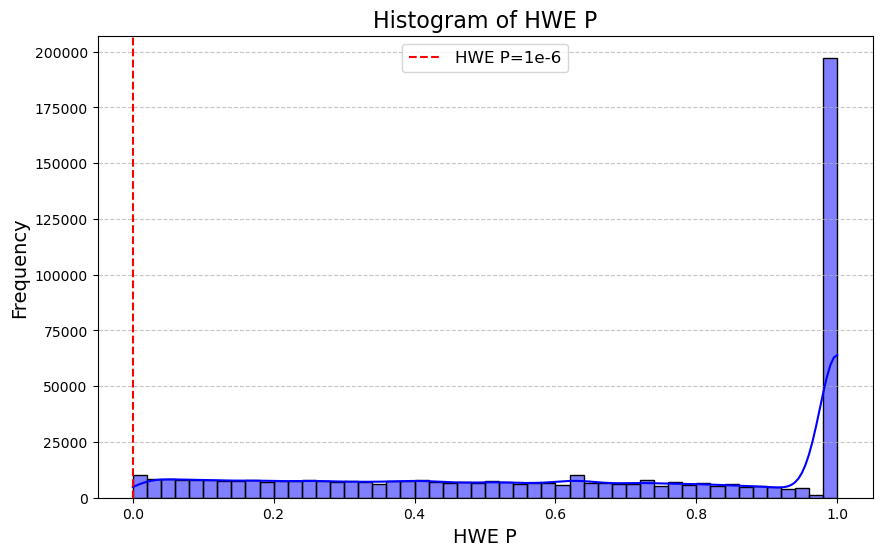

In [14]:
import seaborn as sns

plt.style.use('default')  # 使用默认样式

plt.figure(figsize=(10, 6))
sns.histplot(summary_df['P'], bins=50, kde=True, color='blue') 

plt.axvline(x=1e-6, color='red', linestyle='--', label='HWE P=1e-6')
plt.title('Histogram of HWE P', fontsize=16)
plt.xlabel('HWE P', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

In [7]:
tmp_maf = summary_df[summary_df['MAF'] > 0.01]
tmp_maf_hwe = tmp_maf[tmp_maf['P'] > 1e-6]

/tmp/ipykernel_3734229/2322709672.py:69: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/home/b/b37974/anaconda3/envs/cteph_geno_pro/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


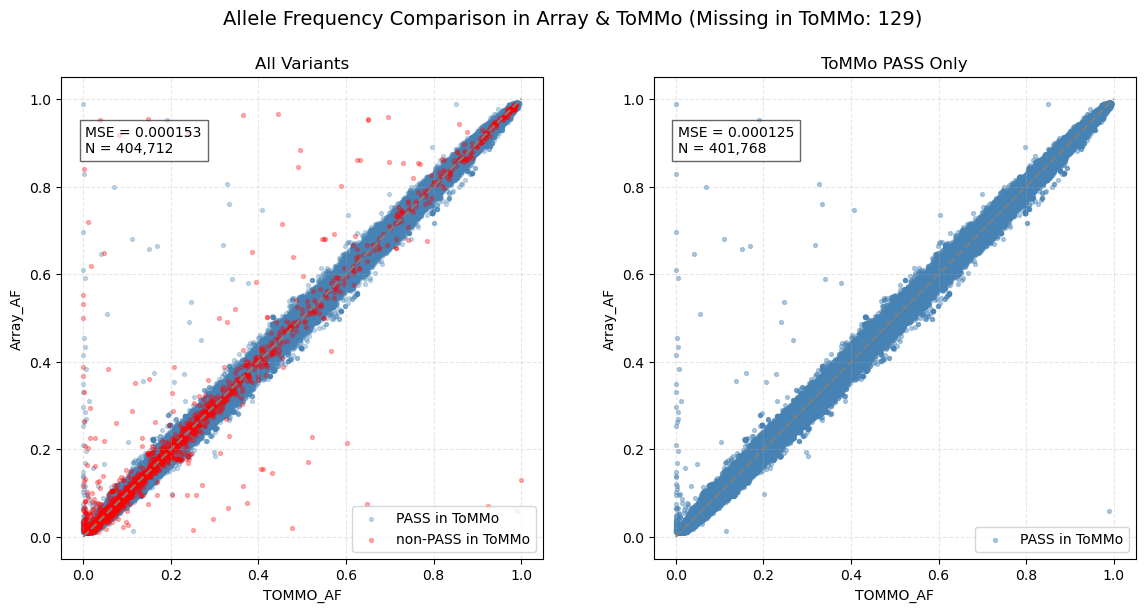

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_allele_frequency_comparison(summary):
    # 提取 AF 值和 FILTER 状态
    af1 = summary['TOMMO_AF'].astype(float)
    af2 = summary['ALT_FREQS'].astype(float)
    filter_status = summary['TOMMO_FILTER']

    # 筛选
    is_pass = filter_status == "PASS"
    is_nonpass = ~is_pass

    af1_pass = af1[is_pass]
    af2_pass = af2[is_pass]

    af1_nonpass = af1[is_nonpass]
    af2_nonpass = af2[is_nonpass]

    # 计算 MSE
    mse_all = np.mean((af1 - af2) ** 2)
    mse_pass = np.mean((af1_pass - af2_pass) ** 2)

    # 计算点的数量
    n_all = len(af1.dropna())
    n_pass = len(af1_pass.dropna())

    # 创建左右子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)

    # 左图：所有变异（PASS + non-PASS）
    ax1.scatter(af1_pass, af2_pass, alpha=0.3, s=8, label='PASS in ToMMo', color='steelblue')
    ax1.scatter(af1_nonpass, af2_nonpass, alpha=0.3, s=8, label='non-PASS in ToMMo', color='red')
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax1.set_xlabel('TOMMO_AF')
    ax1.set_ylabel('Array_AF')
    ax1.set_title('All Variants')
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.legend()
    ax1.set_aspect('equal', adjustable='box')

    # 添加 MSE + N 文本
    text_str1 = (f'MSE = {mse_all:.6f}\n'
                 f'N = {n_all:,}')
    ax1.text(0.05, 0.9, text_str1, transform=ax1.transAxes,
             verticalalignment='top', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6))

    # 右图：仅 PASS
    ax2.scatter(af1_pass, af2_pass, alpha=0.4, s=8, color='steelblue', label='PASS in ToMMo')
    ax2.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax2.set_xlabel('TOMMO_AF')
    ax2.set_ylabel('Array_AF')
    ax2.set_title('ToMMo PASS Only')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend()
    ax2.set_aspect('equal', adjustable='box')

    # 添加 MSE + N 文本
    text_str2 = (f'MSE = {mse_pass:.6f}\n'
                 f'N = {n_pass:,}')
    ax2.text(0.05, 0.9, text_str2, transform=ax2.transAxes,
             verticalalignment='top', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6))

    # 总体布局
    missing_points = len(af1) - len(af1.dropna())
    plt.suptitle(f"Allele Frequency Comparison in Array & ToMMo (Missing in ToMMo: {missing_points:,})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.style.use('default')  # 使用默认样式
    plt.show()

plot_allele_frequency_comparison(summary_df[(summary_df['MAF'] > 0.01) & (summary_df['P'] > 1e-6)])

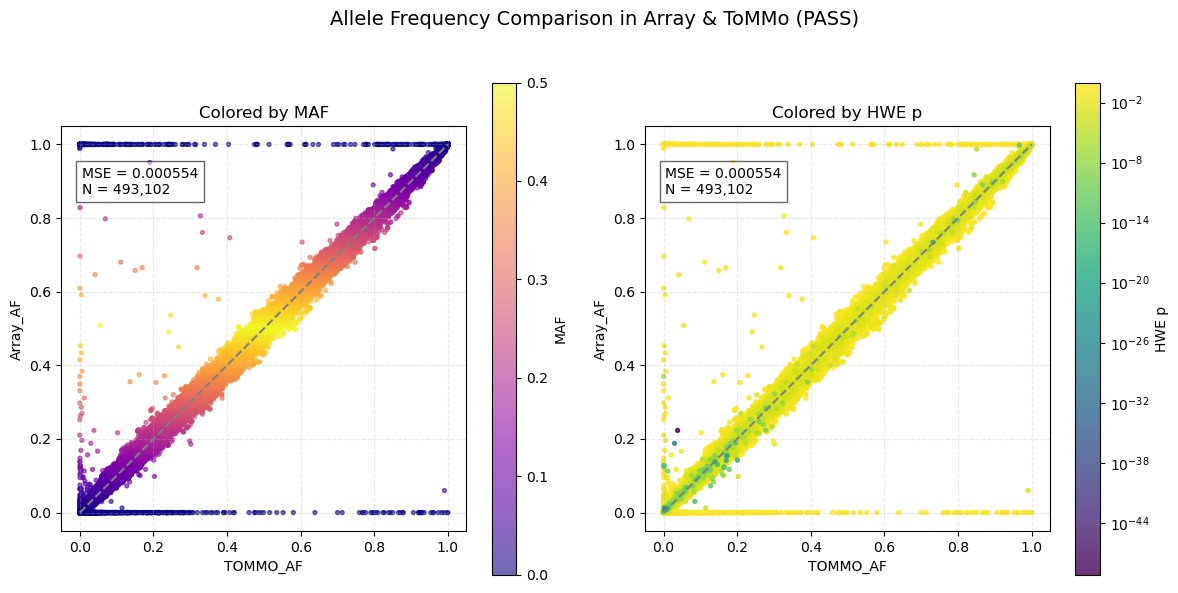

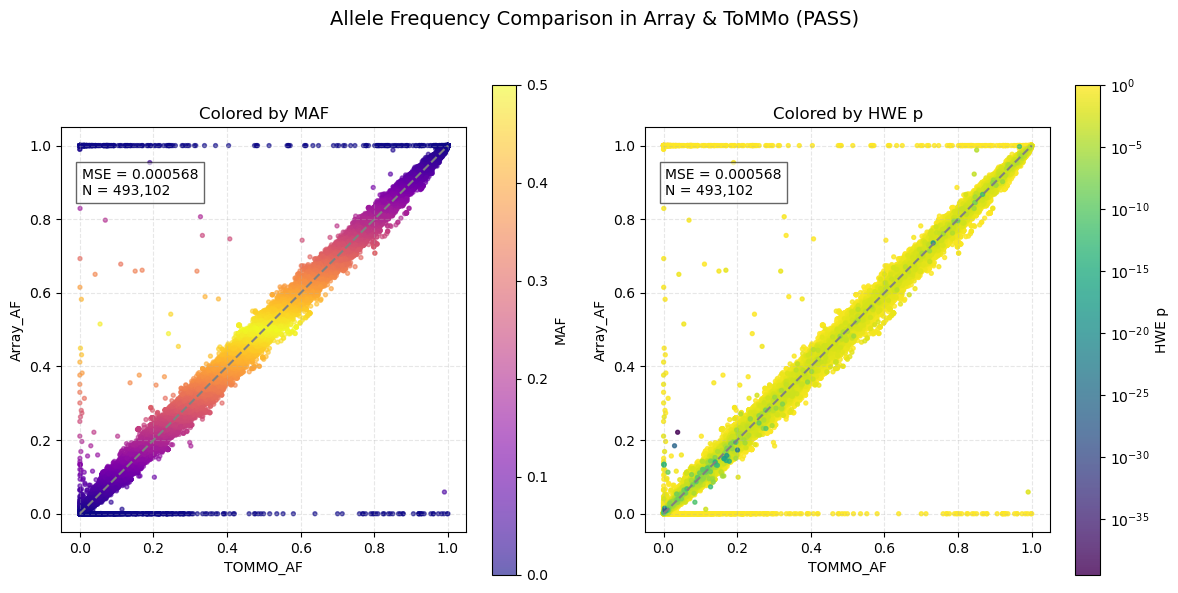

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_pass_variants(summary):
    # 提取列
    af1 = summary['TOMMO_AF'].astype(float)
    af2 = summary['ALT_FREQS'].astype(float)
    filter_status = summary['TOMMO_FILTER']
    maf = summary['MAF'].astype(float)
    pval = summary['P'].astype(float)

    # 筛选 PASS
    is_pass = filter_status == "PASS"

    af1_pass = af1[is_pass]
    af2_pass = af2[is_pass]
    maf_pass = maf[is_pass]
    pval_pass = pval[is_pass]

    # 计算 PASS 的 MSE
    mse_pass = np.mean((af1_pass - af2_pass) ** 2)
    n_pass = len(af1_pass.dropna())

    # 统一颜色映射
    cmap_maf = plt.cm.plasma
    cmap_pval = plt.cm.viridis
    norm_maf = mcolors.Normalize(vmin=maf_pass.min(), vmax=maf_pass.max())
    norm_pval = mcolors.LogNorm(vmin=pval_pass[pval_pass > 0].min(), vmax=pval_pass.max())  # 防止log(0)

    # 创建左右子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=False)

    # --- 左图：颜色 = MAF ---
    sc1 = ax1.scatter(af1_pass, af2_pass, c=maf_pass, cmap=cmap_maf, norm=norm_maf, alpha=0.6, s=8)
    ax1.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax1.set_xlabel('TOMMO_AF')
    ax1.set_ylabel('Array_AF')  
    ax1.set_title('Colored by MAF')
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_aspect('equal', adjustable='box')
    cbar1 = fig.colorbar(sc1, ax=ax1)
    cbar1.set_label('MAF')

    # 添加 MSE + N
    text_str1 = (f'MSE = {mse_pass:.6f}\n'
                 f'N = {n_pass:,}')
    ax1.text(0.05, 0.9, text_str1, transform=ax1.transAxes,
             verticalalignment='top', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6))

    # 对 PASS 点按 P 值排序（小P值在上层）
    sorted_idx = pval_pass.argsort()[::-1]  # 从大到小排序

    # 提取排序后的数据
    af1_sorted = af1_pass.iloc[sorted_idx]
    af2_sorted = af2_pass.iloc[sorted_idx]
    pval_sorted = pval_pass.iloc[sorted_idx]

    # --- 右图：颜色 = P 值 ---
    sc2 = ax2.scatter(
        af1_sorted, af2_sorted,
        c=pval_sorted, cmap=cmap_pval, norm=norm_pval,
        alpha=0.8, s=8
    )
    ax2.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax2.set_xlabel('TOMMO_AF')
    ax2.set_ylabel('Array_AF') 
    ax2.set_title('Colored by HWE p')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_aspect('equal', adjustable='box')
    cbar2 = fig.colorbar(sc2, ax=ax2)
    cbar2.set_label('HWE p')

    # 添加 MSE + N
    text_str2 = (f'MSE = {mse_pass:.6f}\n'
                 f'N = {n_pass:,}')
    ax2.text(0.05, 0.9, text_str2, transform=ax2.transAxes,
             verticalalignment='top', fontsize=10,
             bbox=dict(facecolor='white', alpha=0.6))

    # 总体布局
    plt.suptitle("Allele Frequency Comparison in Array & ToMMo (PASS)", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# 调用函数
plot_pass_variants(summary_df)

In [8]:
# hwe_threshold = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
# maf_threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]

# def calculate_variant_statistics(summary_df, hwe_thresholds, maf_thresholds, apply_pass_filter=False):
#     if apply_pass_filter:
#         summary_df = summary_df[summary_df['TOMMO_FILTER'] == 'PASS']

#     results = []

#     total_variants = len(summary_df)

#     for hwe_threshold in hwe_thresholds:
#         for maf_threshold in maf_thresholds:
#             filtered_variants = summary_df[
#                 (summary_df['P'] > hwe_threshold) & (summary_df['MAF'] > maf_threshold)
#             ]
#             filtered_count = len(filtered_variants)
#             missing_count = total_variants - filtered_count
#             missing_rate = missing_count / total_variants
#             mse = np.mean((filtered_variants['ALT_FREQS'] - filtered_variants['TOMMO_AF']) ** 2)
#             results.append({
#                 'HWE_P_threshold': hwe_threshold,
#                 'MAF_threshold': maf_threshold,
#                 'Filtered_count': filtered_count,
#                 'Total_variants': total_variants,
#                 'Missing_rate': missing_rate,
#                 'MSE': mse
#             })

#     return pd.DataFrame(results)

# threshold_stat = calculate_variant_statistics(summary_df, hwe_threshold, maf_threshold, apply_pass_filter=True)
# threshold_stat_agp3k = calculate_variant_statistics(summary_df_agp3k, hwe_threshold, maf_threshold, apply_pass_filter=True)


In [ ]:
# def plot_threshold_statistics(threshold_stat):
#     plt.figure(figsize=(14, 12))

#     # 左上图：MAF_threshold vs MSE
#     plt.subplot(2, 2, 1)
#     for hwe_p in hwe_threshold:
#         subset = threshold_stat[threshold_stat['HWE_P_threshold'] == hwe_p]
#         plt.plot(subset['MAF_threshold'], subset['MSE'], marker='o', label=f'HWE_P={hwe_p:.1e}')
#     plt.xlabel('MAF_threshold', fontsize=12)
#     plt.ylabel('MSE', fontsize=12)
#     plt.title('MAF_threshold vs MSE', fontsize=14)
#     plt.legend(title='HWE_P_threshold', fontsize=10)
#     plt.grid(alpha=0.5)

#     # 右上图：MAF_threshold vs Missing_rate
#     plt.subplot(2, 2, 2)
#     for hwe_p in hwe_threshold:
#         subset = threshold_stat[threshold_stat['HWE_P_threshold'] == hwe_p]
#         plt.plot(subset['MAF_threshold'], subset['Missing_rate'], marker='o', label=f'HWE_P={hwe_p:.1e}')
#     plt.xlabel('MAF_threshold', fontsize=12)
#     plt.ylabel('Missing_rate', fontsize=12)
#     plt.title('MAF_threshold vs Missing_rate', fontsize=14)
#     plt.legend(title='HWE_P_threshold', fontsize=10)
#     plt.grid(alpha=0.5)

#     # 左下图：HWE_P_threshold vs MSE (颜色为 MAF_threshold)
#     plt.subplot(2, 2, 3)
#     for maf_t in maf_threshold:
#         subset = threshold_stat[threshold_stat['MAF_threshold'] == maf_t]
#         plt.plot(subset['HWE_P_threshold'], subset['MSE'], marker='o', label=f'MAF={maf_t:.2f}')
#     plt.xscale('log')
#     plt.xlabel('HWE_P_threshold', fontsize=12)
#     plt.ylabel('MSE', fontsize=12)
#     plt.title('HWE_P_threshold vs MSE', fontsize=14)
#     plt.legend(title='MAF_threshold', fontsize=10)
#     plt.grid(alpha=0.5)

#     # 右下图：HWE_P_threshold vs Missing_rate (颜色为 MAF_threshold)
#     plt.subplot(2, 2, 4)
#     for maf_t in maf_threshold:
#         subset = threshold_stat[threshold_stat['MAF_threshold'] == maf_t]
#         plt.plot(subset['HWE_P_threshold'], subset['Missing_rate'], marker='o', label=f'MAF={maf_t:.2f}')
#     plt.xscale('log')
#     plt.xlabel('HWE_P_threshold', fontsize=12)
#     plt.ylabel('Missing_rate', fontsize=12)
#     plt.title('HWE_P_threshold vs Missing_rate', fontsize=14)
#     plt.legend(title='MAF_threshold', fontsize=10)
#     plt.grid(alpha=0.5)

#     plt.tight_layout()
#     plt.show()

# plot_threshold_statistics(threshold_stat)
# plot_threshold_statistics(threshold_stat_agp3k)

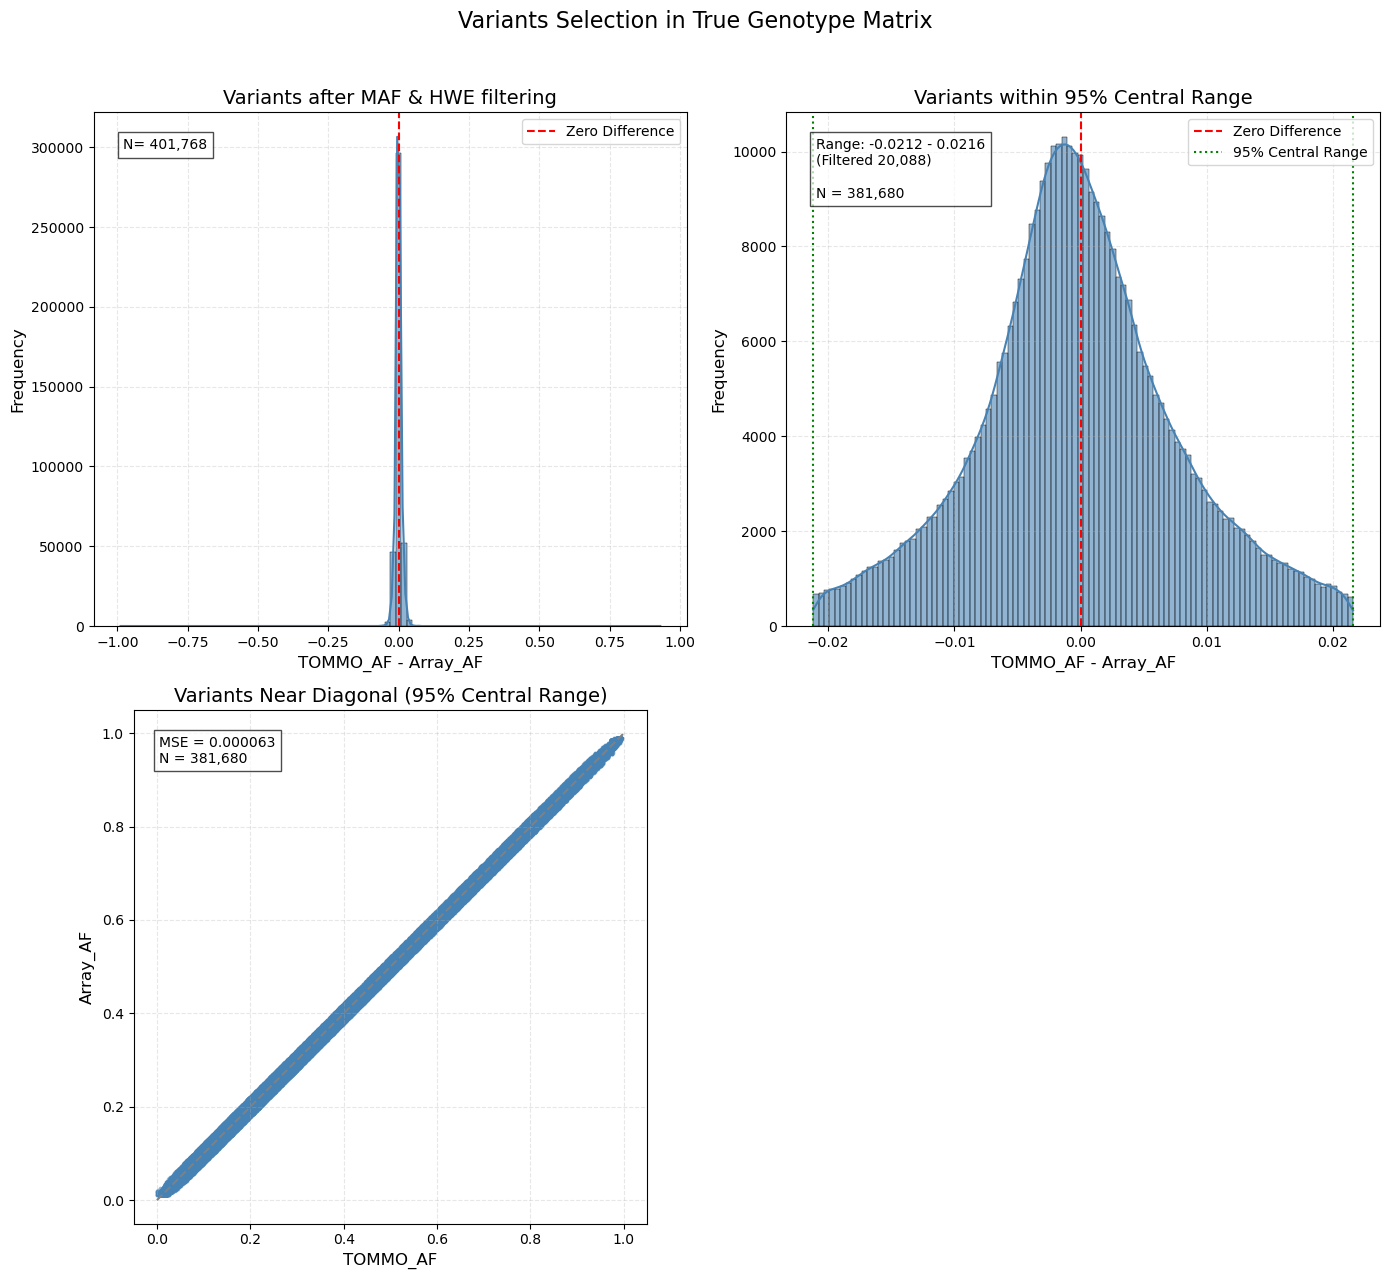

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def select_high_confidence_variants(summary, hwe_threshold=1e-6, maf_threshold=0.01, confidence=0.95):
 
    # Step 1: 正确的筛选流程
    # 1.1 PASS筛选
    pass_summary = summary[summary['TOMMO_FILTER'] == 'PASS']

    # 1.2 在PASS的基础上做MAF筛选
    maf_fail_mask = pass_summary['MAF'] <= maf_threshold
    n_maf_filtered = maf_fail_mask.sum()  # 被MAF过滤掉的数量
    maf_pass_summary = pass_summary[~maf_fail_mask]

    # 1.3 在MAF通过基础上做HWE筛选
    hwe_fail_mask = maf_pass_summary['P'] <= hwe_threshold
    n_hwe_filtered = hwe_fail_mask.sum()  # 被HWE过滤掉的数量
    final_summary = maf_pass_summary[~hwe_fail_mask]

    # 准备绘图数据
    af1 = final_summary['TOMMO_AF'].astype(float)
    af2 = final_summary['ALT_FREQS'].astype(float)
    af_difference = af1 - af2

    # Step 4: 中心95%范围
    lower_bound = np.quantile(af_difference, (1 - confidence) / 2)
    upper_bound = np.quantile(af_difference, 1 - (1 - confidence) / 2)
    mask_conf = (af_difference >= lower_bound) & (af_difference <= upper_bound)

    af_difference_conf = af_difference[mask_conf]
    af1_conf = af1[mask_conf]
    af2_conf = af2[mask_conf]

    # Step 5: 计算中心95%数据的 MSE
    mse_conf = np.mean((af1_conf - af2_conf) ** 2)

    # Step 6: 绘制
    fig, axes = plt.subplots(2, 2, figsize=(14, 13))

    ax1 = axes[0, 0]  # 左上
    ax2 = axes[0, 1]  # 右上
    ax3 = axes[1, 0]  # 左下
    ax4 = axes[1, 1]  # 右下

    # -- 左上图：全部数据差异分布 --
    sns.histplot(af_difference, bins=100, kde=True, color='steelblue', edgecolor='black', alpha=0.6, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--', label='Zero Difference')
    ax1.set_xlabel("TOMMO_AF - Array_AF", fontsize=12)
    ax1.set_ylabel("Frequency", fontsize=12)
    ax1.set_title("Variants after MAF & HWE filtering", fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.legend()

    text_str1 = (f'N= {len(af_difference):,}')
    ax1.text(0.05, 0.95, text_str1, transform=ax1.transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7), fontsize=10)

    # -- 右上图：中心95%数据差异分布 --
    sns.histplot(af_difference_conf, bins=100, kde=True, color='steelblue', edgecolor='black', alpha=0.6, ax=ax2)
    ax2.axvline(x=0, color='red', linestyle='--', label='Zero Difference')
    ax2.axvline(lower_bound, color='green', linestyle=':', label=f'{int(confidence*100)}% Central Range')
    ax2.axvline(upper_bound, color='green', linestyle=':')
    ax2.set_xlabel("TOMMO_AF - Array_AF", fontsize=12)
    ax2.set_ylabel("Frequency", fontsize=12)
    ax2.set_title(f"Variants within {int(confidence*100)}% Central Range", fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.legend()

    conf_filtered_count = len(af_difference) - len(af_difference_conf)
    text_str2 = (f'Range: {lower_bound:.4f} - {upper_bound:.4f}\n'
                 f'(Filtered {conf_filtered_count:,})\n'
                 '\n'
                 f'N = {len(af_difference_conf):,}')
    ax2.text(0.05, 0.95, text_str2, transform=ax2.transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7), fontsize=10)

    # -- 左下图：TOMMO_AF vs Array_AF (仅95%中心数据) --
    ax3.scatter(af1_conf, af2_conf, alpha=0.4, s=3, color='steelblue')
    ax3.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax3.set_xlabel('TOMMO_AF', fontsize=12)
    ax3.set_ylabel('Array_AF', fontsize=12)
    ax3.set_title(f"Variants Near Diagonal ({int(confidence*100)}% Central Range)", fontsize=14)
    ax3.grid(True, linestyle='--', alpha=0.3)
    ax3.set_aspect('equal', adjustable='box')

    # 添加MSE到左下角图
    text_str3 = (f'MSE = {mse_conf:.6f}\n'
                 f'N = {len(af1_conf):,}')
    ax3.text(0.05, 0.95, text_str3, transform=ax3.transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7), fontsize=10)

    # -- 右下角空白 --
    ax4.axis('off')  # 隐藏右下角的空白子图

    # 总体布局
    plt.suptitle("Variants Selection in True Genotype Matrix", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 上方稍微留点空
    plt.show()

    return final_summary[mask_conf]['ID'].tolist()

selected_ids = select_high_confidence_variants(summary_df, hwe_threshold=1e-6, maf_threshold=0.01, confidence=0.95)

In [68]:
# 保存选中的变异 ID 到文件
with open('selected_variants.txt', 'w') as f:
    for variant_id in selected_ids:
        f.write(f"{variant_id}\n")